## Background

Using devices such as Jawbone Up, Nike FuelBand, and Fitbit it is now possible to collect a large amount of data about personal activity relatively inexpensively. These type of devices are part of the quantified self movement – a group of enthusiasts who take measurements about themselves regularly to improve their health, to find patterns in their behavior, or because they are tech geeks. One thing that people regularly do is quantify how much of a particular activity they do, but they rarely quantify how well they do it. In this project, your goal will be to use data from accelerometers on the belt, forearm, arm, and dumbell of 6 participants. They were asked to perform barbell lifts correctly and incorrectly in 5 different ways. More information is available from the website here: http://web.archive.org/web/20161224072740/http:/groupware.les.inf.puc-rio.br/har (see the section on the Weight Lifting Exercise Dataset).

In [2]:
library(caret); library(tictoc); library(ggcorrplot)

#### Load the data sets

In [10]:
train_raw <- read.csv("pml-training.csv", na.strings=c("NA","#DIV/0!",""))
testing <- read.csv("pml-testing.csv", na.strings=c("NA","#DIV/0!",""))

In [11]:
str(train_raw)

'data.frame':	19622 obs. of  160 variables:
 $ X                       : int  1 2 3 4 5 6 7 8 9 10 ...
 $ user_name               : Factor w/ 6 levels "adelmo","carlitos",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ raw_timestamp_part_1    : int  1323084231 1323084231 1323084231 1323084232 1323084232 1323084232 1323084232 1323084232 1323084232 1323084232 ...
 $ raw_timestamp_part_2    : int  788290 808298 820366 120339 196328 304277 368296 440390 484323 484434 ...
 $ cvtd_timestamp          : Factor w/ 20 levels "02/12/2011 13:32",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ new_window              : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ num_window              : int  11 11 11 12 12 12 12 12 12 12 ...
 $ roll_belt               : num  1.41 1.41 1.42 1.48 1.48 1.45 1.42 1.42 1.43 1.45 ...
 $ pitch_belt              : num  8.07 8.07 8.07 8.05 8.07 8.06 8.09 8.13 8.16 8.17 ...
 $ yaw_belt                : num  -94.4 -94.4 -94.4 -94.4 -94.4 -94.4 -94.4 -94.4 -94.4 -94.4 ...
 $ total_accel_belt    

In [12]:
# use the column starting from 'roll_belt' & remove NAs
features <- names(testing[, colSums(is.na(testing)) == 0])[8:59]


train_raw <- train_raw[,c(features,"classe")]
testing <- testing[,c(features,"problem_id")]

In [13]:
dim(train_raw); dim(testing)

# check class imbalance 
table(train_raw$classe)

[1] 19622    53

[1] 20 53


   A    B    C    D    E 
5580 3797 3422 3216 3607 

#### Remove columns with NA > 90% and nearZeroVar

In [37]:
# missing values more than 90%
# mv <- lapply(train_raw, function(x) sum(is.na(x)/nrow(train_raw)))
# train_raw <- train_raw[, mv<=0.9]
# testing <- testing[, mv<=0.9]
# train_raw <- train_raw[, colSums(is.na(train_raw)) == 0] 
# testing <- testing[, colSums(is.na(testing)) == 0] 
# dim(train_raw); dim(testing)

[1] 19622    53

[1] 20 53

In [15]:
# nearZeroVar
# nzv <- nearZeroVar(train_raw, freqCut = 95/5)
# print(nzv)
# train_raw <- train_raw[, -nzv]
# testing <- testing[, -nzv]
# dim(train_raw); dim(testing)

integer(0)


#### Remove highly correlated variables (e.g., > 90%)

In [16]:
# find correlations and remove
nums <- sapply(train_raw, is.numeric)
highlyCorDescr <- findCorrelation(cor(train_raw[, nums], use="complete.obs"), cutoff = 0.9)
train_raw <- train_raw[, -highlyCorDescr]
testing <- testing[, -highlyCorDescr]
dim(train_raw); dim(testing)

[1] 19622    46

[1] 20 46

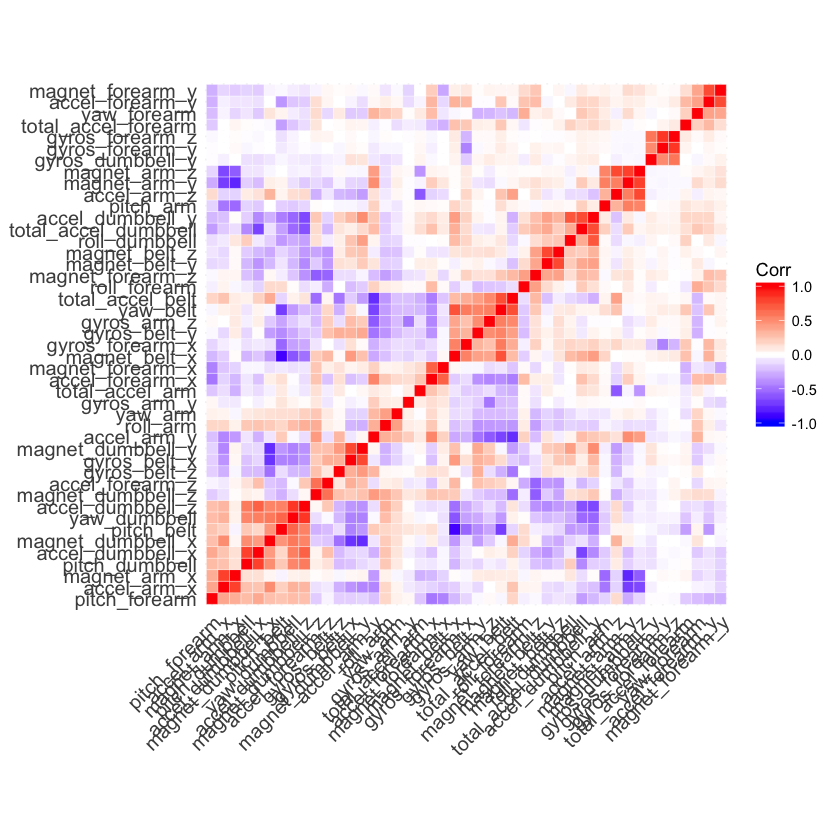

In [17]:
# plot correlation 
nums <- sapply(train_raw, is.numeric)
corr <- round(cor(train_raw[, nums], use = "complete.obs"), 2)
ggcorrplot(corr, hc.order = TRUE, outline.col = "white") 


#### Data partition

In [18]:
set.seed(12345)
inTrain <- createDataPartition(y=train_raw$classe, p=0.7, list=FALSE)

training <- train_raw[inTrain, ]
validation <- train_raw[-inTrain, ]

In [19]:
# check dimensions again
dflist <- list(train_raw, training, validation, testing)
sapply(dflist, dim)

# check class imbalance 
table(training$classe)

19622,13737,5885,20
46,46,46,46



   A    B    C    D    E 
3906 2658 2396 2252 2525 

### Modeling & Prediction

#### Classe type: 
- specification (Class A) 
- throwing the elbows to the front (Class B)
- lifting the dumbbell only halfway (Class C)
- lowering the dumbbell only halfway (Class D) 
- throwing the hips to the front (Class E)

#### Try RandomForest model

use 10-fold cross-validation & ntree=100

In [20]:
tic("ModelRF") # calculate time
setting <- trainControl(method="cv", classProbs=TRUE, 
                        savePredictions=TRUE,
                        allowParallel=TRUE, 
                        number = 10)
ModelRF <- train(classe ~ ., data=training, 
                 method="rf", 
                 trControl=setting, 
                 ntree=100)
toc()  # about 7 min
ModelRF

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



ModelRF: 415.416 sec elapsed


Random Forest 

13737 samples
   45 predictor
    5 classes: 'A', 'B', 'C', 'D', 'E' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 12362, 12362, 12364, 12363, 12363, 12363, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9909005  0.9884884
  23    0.9918465  0.9896858
  45    0.9879153  0.9847128

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 23.

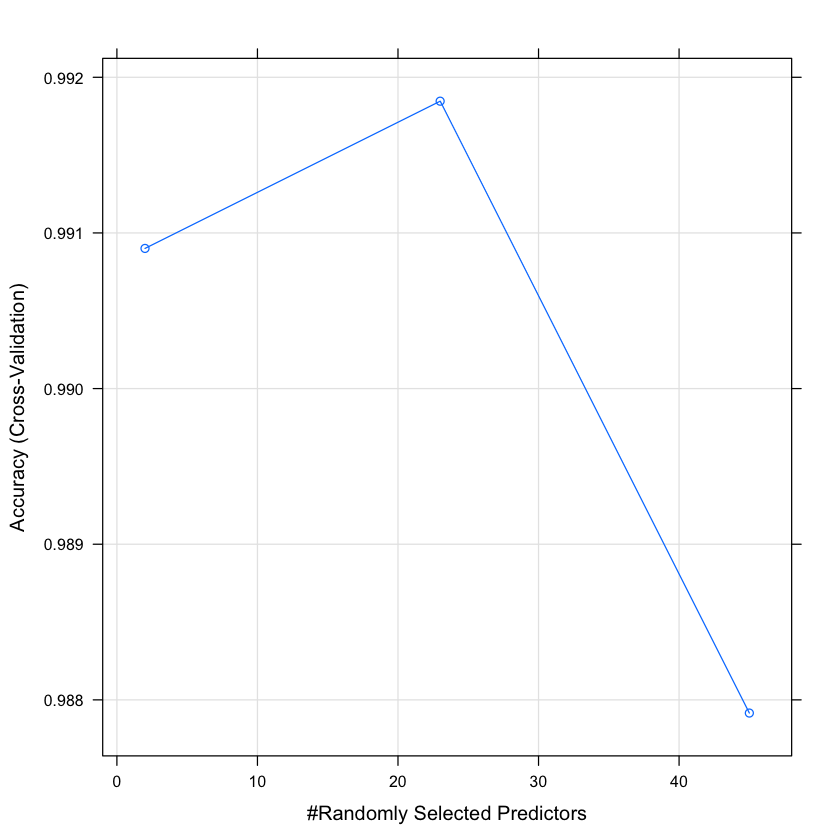

In [21]:
plot(ModelRF)

In [22]:
PredRF <- predict(ModelRF, validation)
Accuracy_RF <- confusionMatrix(PredRF, validation$classe)$overall['Accuracy']

In [23]:
confusionMatrix(PredRF, validation$classe)
RF_confuse <- as.matrix(confusionMatrix(PredRF, validation$classe))

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1670    9    0    0    0
         B    4 1126    9    0    0
         C    0    4 1012   12    0
         D    0    0    5  952    5
         E    0    0    0    0 1077

Overall Statistics
                                         
               Accuracy : 0.9918         
                 95% CI : (0.9892, 0.994)
    No Information Rate : 0.2845         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.9897         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9976   0.9886   0.9864   0.9876   0.9954
Specificity            0.9979   0.9973   0.9967   0.9980   1.0000
Pos Pred Value         0.9946   0.9886   0.9844   0.9896   1.0000
Neg Pred Value         0.9990   0.9973   0.9971   0.9976   0.9990
Prevalence            

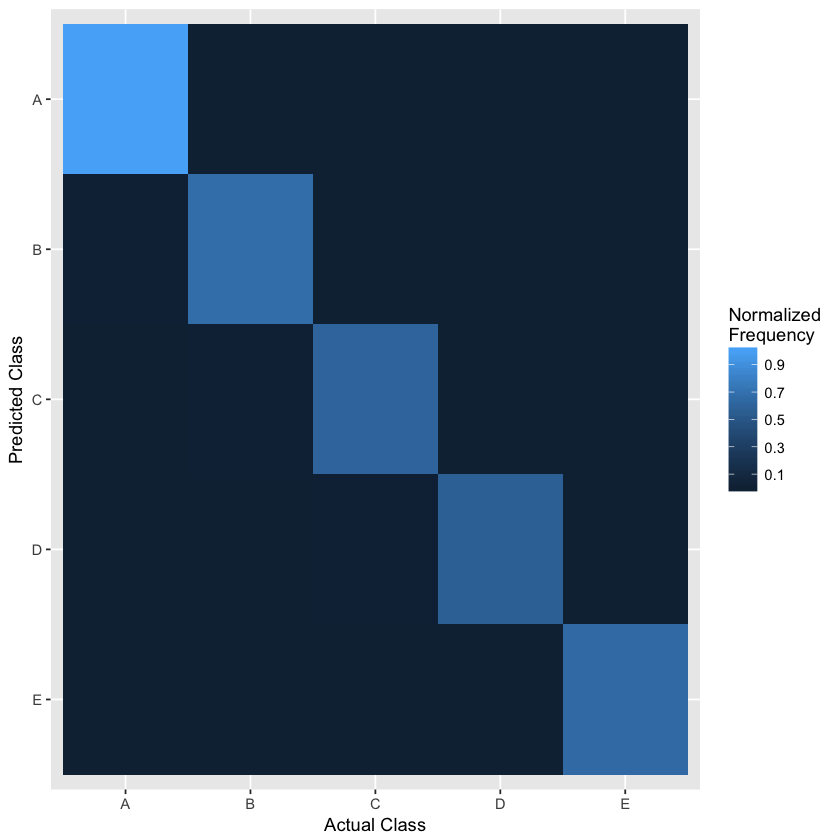

In [24]:
# Plot Confusion Matrix
normalize <- function(m){
     (m - min(m))/(max(m)-min(m))
}

# normalize confusion matrix
input.matrix <- normalize(RF_confuse)


colnames(input.matrix) = c("A", "B", "C", "D", "E")
rownames(input.matrix) = colnames(input.matrix)

confusion <- as.data.frame(as.table(input.matrix))

plot <- ggplot(confusion)
plot + geom_tile(aes(x=Var1, y=Var2, fill=Freq)) + 
    scale_x_discrete(name="Actual Class") + 
    scale_y_discrete(limits = rev(levels(confusion$Var2)) ,name="Predicted Class") + 
    scale_fill_gradient(breaks=seq(from=-.5, to=4, by=.2)) + 
    labs(fill="Normalized\nFrequency") 

#### Try SVM linear model

In [33]:
# choose C parameter for tuning
grid <- expand.grid(C = c(1, 100, 200, 300))

tic("ModelSVM") # calculate time
setting <- trainControl(method="cv", 5)
ModelSVM <- train(classe ~ ., data=training, 
                              method="svmLinear", 
                              trControl=setting, 
                              preProcess = c("center", "scale"),
                              tuneGrid = grid,
                              tuneLength = 10)
toc()  # about 2.4 hours
ModelSVM

ModelSVM: 8737.403 sec elapsed


Support Vector Machines with Linear Kernel 

13737 samples
   45 predictor
    5 classes: 'A', 'B', 'C', 'D', 'E' 

Pre-processing: centered (45), scaled (45) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 10990, 10988, 10989, 10991, 10990 
Resampling results across tuning parameters:

  C    Accuracy   Kappa    
    1  0.7503101  0.6822983
  100  0.7552608  0.6886463
  200  0.7552607  0.6886487
  300  0.7540952  0.6871524

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was C = 100.

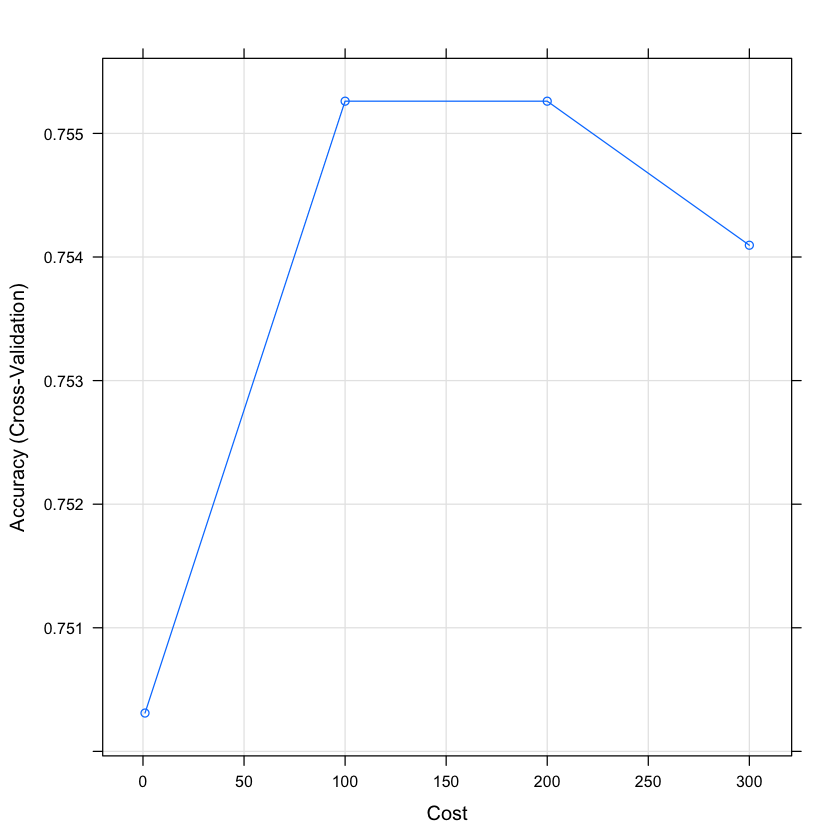

In [34]:
plot(ModelSVM)

In [35]:
PredSVM <- predict(ModelSVM, validation)
Accuracy_SVM <- confusionMatrix(PredSVM, validation$classe)$overall['Accuracy']

In [36]:
confusionMatrix(PredSVM, validation$classe)
SVM_confuse <- as.matrix(confusionMatrix(PredSVM, validation$classe))

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1533  168   97   77   43
         B   37  791   86   51  166
         C   53   74  739  128   72
         D   39   21   71  665   95
         E   12   85   33   43  706

Overall Statistics
                                          
               Accuracy : 0.7534          
                 95% CI : (0.7422, 0.7644)
    No Information Rate : 0.2845          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6864          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9158   0.6945   0.7203   0.6898   0.6525
Specificity            0.9086   0.9284   0.9327   0.9541   0.9640
Pos Pred Value         0.7993   0.6994   0.6932   0.7464   0.8032
Neg Pred Value         0.9645   0.9268   0.9404   0.9401   0.9249
Prevalence    

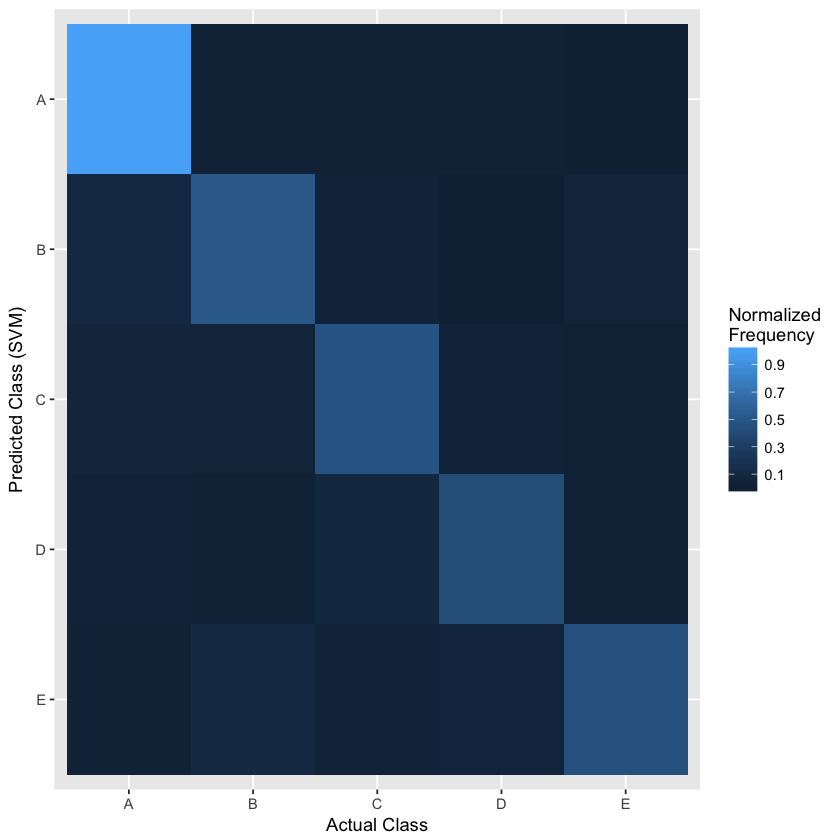

In [37]:
# Plot Confusion Matrix
normalize <- function(m){
     (m - min(m))/(max(m)-min(m))
}

# normalize confusion matrix
input.matrix <- normalize(SVM_confuse)


colnames(input.matrix) = c("A", "B", "C", "D", "E")
rownames(input.matrix) = colnames(input.matrix)

confusion <- as.data.frame(as.table(input.matrix))

plot <- ggplot(confusion)
plot + geom_tile(aes(x=Var1, y=Var2, fill=Freq)) + 
    scale_x_discrete(name="Actual Class") + 
    scale_y_discrete(limits = rev(levels(confusion$Var2)) ,name="Predicted Class (SVM)") + 
    scale_fill_gradient(breaks=seq(from=-.5, to=4, by=.2)) + 
    labs(fill="Normalized\nFrequency") 

### Prediction on test set and model comparison

In [38]:
Accuracy_RF ; Accuracy_SVM

Accuracy 
0.9918437

Accuracy 
0.753441

The RandomForest model has slightly better accuracy than the SVM model but is comparable. 

In [40]:
PredRF_test <- predict(ModelRF,  testing)
PredSVM_test <- predict(ModelSVM, testing)

#### Predict the test set labels from both models

In [41]:
PredRF_test

[1] B A B A A E D B A A B C B A E E A B B B
Levels: A B C D E

In [42]:
PredSVM_test

[1] C A B C A C D A A A C A B A E E A B B B
Levels: A B C D E

### Conclusion

The RandomForest model has much higher accuracy (0.99 vs. 0.75) than the SVM model and needs less time for modeling (7 min vs. 2.4 hours). Therefore, the RandomForest model is the better choice here.